# Manual Backpropgation Example#2  , a neuron

In [159]:
%pip install numpy matplotlib

7078.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Neuron 

<img src="./public/neurons.png" alt="neuron" />


Neuron is samll weighted and summed mathemical function , each nuron is tiny building block

takes the input multiply it with the weights , then add a bias , apply non linearity (activation function)

In [160]:
%pip install graphviz

7084.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [161]:
import math
import numpy as np

In [162]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        name = getattr(n, 'label', '')
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # for any value in the graph, create a rectangular('record') op node for it
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to n1._op to n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [163]:

class Value:
    def __init__(self, data , _children=() , _op = ''  ,label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None 

    def __repr__(self):
        return "Value(data = %.4f, op = %s)" % (self.data, self._op)
    
    def __add__(self , other):
        out = Value(self.data + other.data , (self , other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self , other):
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t,(self , ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward() 

Tanh function : activation function squash the value in between -1 to 1 

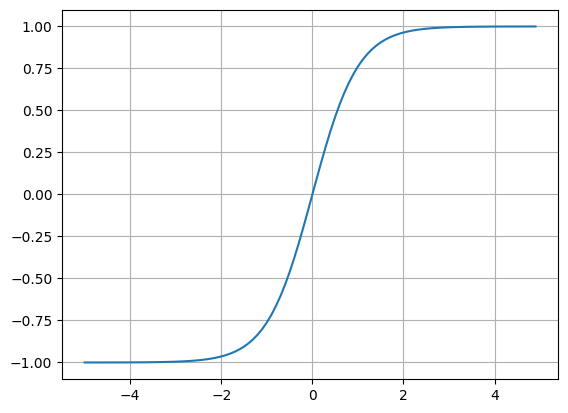

In [164]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1)))
plt.grid();


In [165]:
# inputs of nuron 2d 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432 , label='b')

# forward pass
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# neuron output
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



# Manual backpropgation 

1.  Start With final Value `o`

    Derivative of O with : 1 

    o.grad = 1

2. backprograte through tanh , derivative of tanh

    ```math
    d.tanh/dx = 1 - tanh^2x
    ```

    so 
    ```math
    do/dn = 1 - o^2
    ```

3. According to chain rule 


    local derivative of 

    ```math
    db/dn = 1.0
    ```
    ```math
    d(x1*w1 + x2*w2)/dn = 1.0
    ```

    Chain rule : 
    ```math
    db/do = 1 * n.grad
    ```

    ```math
    d(x1*w1 + x2*w2)/do = 1 * n.grad
    ```
4. Same apply for this node 

    here the local derivative of 
    
    ```math
    d(x1.w1)/d(x1.w1+x2.w2) = 1.0
    ```

    ```math
    d(x2.w2)/d(x1.w1+x2.w2) = 1.0
    ```

    After chain rule :
    ```math
    d(x1.w1)/do = 1 * x1w1x2w2.grad
    ```
    ```math             
    d(x2.w2)/do = 1 * x1w1x2w2.grad
    ```


In [166]:


o.backward()

# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# b._backward()
# x1w1._backward()
# x2w2._backward()

# o.grad = 1.0
# n.grad = 1 - o.data**2

# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# Graph

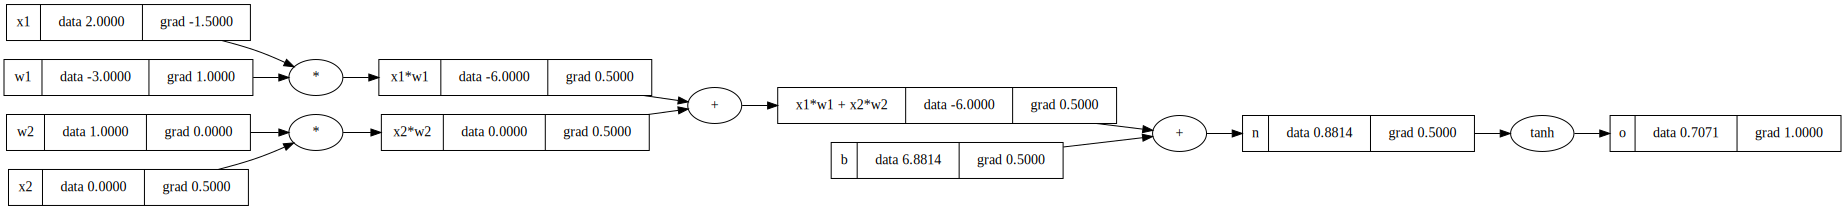

In [167]:
draw_dot(o)